In [28]:
import ipyleaflet as leaf
import pandas as pd
import numpy as np
import sklearn as sk
import math

In [29]:
from matplotlib.colors import rgb2hex
from matplotlib.pyplot import xticks, yticks
import pylab as plt

In [12]:
from pyspark import SparkContext
sc = SparkContext(master="local[2]")

In [13]:
from pyspark import SQLContext
sqlContext = SQLContext(sc)

In [21]:
df = sqlContext.read.parquet("../Data/decon_NY_SNWD.parquet/")
df.show(5)

+-----------+-----------+--------------------+----+------------------+-------------------+-------------------+------------------+-------------------+------------------+----------------+------------------+------------------+---------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+---------+-----+
|    Station|Measurement|              Values|Year|           coeff_1|            coeff_2|            coeff_3|           coeff_4|            coeff_5|        dist_coast|       elevation|          latitude|         longitude|     name|             res_1|              res_2|             res_3|              res_4|              res_5|           res_mean|total_var|State|
+-----------+-----------+--------------------+----+------------------+-------------------+-------------------+------------------+-------------------+------------------+----------------+------------------+------------------+---------+------------------+------------

In [16]:
# count and avg of coeff_1

feat = "coeff_1"
sqlContext.registerDataFrameAsTable(df, "weather")

In [20]:
query = """
SELECT station, latitude, longitude, elevation, Dist_coast, %s
FROM weather
"""%feat

df1 = sqlContext.sql(query)
df1.show(5)

+-----------+------------------+------------------+----------------+------------------+------------------+
|    station|          latitude|         longitude|       elevation|        Dist_coast|           coeff_1|
+-----------+------------------+------------------+----------------+------------------+------------------+
|USW00014735|42.743099212646484|-73.80919647216797|95.0999984741211|175.44400024414062|-659.3190458468584|
|USW00014735|42.743099212646484|-73.80919647216797|95.0999984741211|175.44400024414062|-636.3811845052854|
|USW00014735|42.743099212646484|-73.80919647216797|95.0999984741211|175.44400024414062|-33.31222533832221|
|USW00014735|42.743099212646484|-73.80919647216797|95.0999984741211|175.44400024414062|-671.9063469563363|
|USW00014735|42.743099212646484|-73.80919647216797|95.0999984741211|175.44400024414062|1040.8443508115042|
+-----------+------------------+------------------+----------------+------------------+------------------+
only showing top 5 rows



In [23]:
df2 = df1.groupBy(["station", "latitude", "longitude", "elevation", "Dist_coast"]).agg({"station" : "count", feat: "mean"})
df2.show(5)

+-----------+------------------+------------------+------------------+------------------+--------------+-------------------+
|    station|          latitude|         longitude|         elevation|        Dist_coast|count(station)|       avg(coeff_1)|
+-----------+------------------+------------------+------------------+------------------+--------------+-------------------+
|USC00306301|41.150001525878906|   -73.86669921875| 9.100000381469727|23.492300033569336|             5|-34.633676728443675|
|USC00303184| 42.87670135498047|-77.03079986572266| 218.8000030517578|341.45599365234375|            21|  52.92724130100481|
|USC00304808| 42.24720001220703|          -78.8125|495.29998779296875| 375.9670104980469|            65|  533.3122301843116|
|USC00300540|    42.11669921875|   -75.11669921875|             473.0| 174.8520050048828|             8|  207.7429066113467|
|USC00307705| 42.67720031738281|-75.50669860839844|333.79998779296875| 242.9669952392578|            67| 126.22023156398511|


In [24]:
pdf = df2.toPandas()
pdf.sort_values(by=["station"], inplace=True)
pdf.head(5)

,station,latitude,longitude,elevation,Dist_coast,count(station),avg(coeff_1)
294,USC00300015,43.900002,-76.066704,121.900002,376.802002,25,1550.908341
182,USC00300023,42.101398,-77.234398,304.500000,296.167999,46,-90.305486
275,USC00300047,42.646099,-73.747200,0.000000,166.001007,4,-107.478530
69,USC00300055,43.272202,-78.166397,134.100006,436.303009,29,43.864554
239,USC00300063,42.469700,-73.926697,185.000000,152.889999,5,-6.938177


In [25]:
max_lat = pdf["latitude"].max()
max_long = pdf["longitude"].max()
min_lat = pdf["latitude"].min()
min_long = pdf["longitude"].min()

In [26]:
_avg = "avg(%s)"%feat
_max = pdf[_avg].max()
_min = pdf[_avg].min()

(_avg, _max, _min)

('avg(coeff_1)', 5030.689567004181, -792.3395482545591)

In [27]:
cmap = plt.get_cmap("jet")
def get_color(val):
    x = (val - _min) / (_max - _min)
    return rgb2hex(cmap(x)[:3])

([], <a list of 0 Text yticklabel objects>)

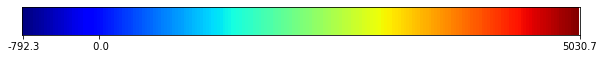

In [38]:
plt.figure(figsize=[10, 1])
ax = plt.subplot(111)

vals = cmap(np.arange(0, 1, 0.005))[:, :3]
vals3 = np.stack([vals] * 10)
ax.imshow(vals3)

mid_pnt = 200. * (-(_min) / (_max - _min))
xticks((0, mid_pnt, 200), ["%4.1f"%v for v in (_min, 0., _max)])
yticks(())

In [39]:
center = [(min_lat + max_lat) / 2, (min_long + max_long) / 2]
zoom = 6

In [43]:
m = leaf.Map(default_tiles=leaf.TileLayer(opacity=1.0), center=center, zoom=zoom)
r = leaf.Rectangle(bounds=[[min_lat, min_long], [max_lat, max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin = (max_lat - min_lat) / 4
long_margin = (max_long - min_long) / 4

circles = []
for index, row in pdf.iterrows():
    _lat = row["latitude"]
    _long = row["longitude"]
    _count = row["count(station)"]
    _coeff = row[_avg]
    cir = leaf.Circle(
        location=(_lat, _long),
        radius=int(1200 * np.sqrt(_count + 0.0)),
        weight=1,
        color="#F00",
        opacity=0.8,
        fill_opacity=0.4,
        fill_color=get_color(_coeff)
    )
    circles.append(cir)
    m.add_layer(cir)

display(m)

Map(center=[42.75955009460449, -75.94625091552734], controls=(ZoomControl(options=['position', 'zoom_in_text',…